#Predicting Valorant Champions
Tutorial by Marc Saura

##Introduction
 The [Valorant Champions Tour](https://valorantesports.com/) (VCT) is the global competitive esports
tournament for the video game [Valorant](https://playvalorant.com/en-us/?gad_source=1&gclid=CjwKCAjwouexBhAuEiwAtW_ZxzPapjXBq8VTaQ4epWC3VxByPl5HiSgLA58v3iMji3qY2wVB_MYZABoC9ccQAvD_BwE&gclsrc=aw.ds). By synthesizing and analyzing the data from the
tour so far, I can gain various insights and competitive advantages which
can be applied to improve my individual and team performance. Beyond myself, creating a model to predict individual and team performance in this reletively new game can help amateurs and pros alike to know which skills are most important to target for improvement. Additionally, this sort of predictive power will empower professional organizations and talent scouts in the recruitment of players, leading to an overall increase of talent in the scene.  

These effects have the power to propel Valorant as a global esport.

## Data Curation
Typically, complete statistics of the VCT are not officially published. Fortunately for me however, a passionate member of the community by the name Ediashta Revindra has kindly taken the time to compile nearly all relevant statistical data regarding the VCT. I have chosen to investigate the following [dataset](https://www.kaggle.com/datasets/ediashtarevin/vct-champions-2023-stats/data) as it provides the most complete view of VCT 2023 season, accounting for the majority of it's matches.


Downloading the data from [Kaggle](https://www.kaggle.com/) yielded the following [player_stats.csv](https://www.kaggle.com/datasets/ediashtarevin/vct-champions-2023-stats/download?datasetVersionNumber=2) which contains over 6000 samples of player match statistics, represented by the following: match id, game id, team, team score, opponent,
       opponent score, win/lose, map, map pick, player id, player,
       agent, rating, acs(average combat score), kills, deaths, assists, kast%, adr(average damage per round),
       Headshot %, first kills, and first deaths.


##Imports

In [19]:
# Import necessary modules
import pandas as pd
import re
from scipy.stats import ttest_ind, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

[Pandas](https://pandas.pydata.org/) is a software library written for the Python programming language for data manipulation and analysis. To access the VCT data, I used the Pandas library to extract and store the data into a Pandas dataframe:

In [20]:
# Use Pandas to read the player data into a dataframe and print the
# first few rows of the dataframe
df = pd.read_csv("/content/player_stats.csv")
df

,Unnamed: 0,match_id,game_id,team,score_team,opponent,score_opp,win_lose,map,map_pick,...,rating,acs,kill,death,assist,kast%,adr,hs%,fk,fd
0,0,53658,119512,ZETA,5,DRX,13,opponent win,Ascent,opponent pick,...,1.19,239,15,11,6,72%,146,16%,1,0
1,1,53658,119512,ZETA,5,DRX,13,opponent win,Ascent,opponent pick,...,0.84,234,15,14,6,61%,145,32%,1,4
2,2,53658,119512,ZETA,5,DRX,13,opponent win,Ascent,opponent pick,...,0.68,173,10,15,2,67%,123,18%,4,2
3,3,53658,119512,ZETA,5,DRX,13,opponent win,Ascent,opponent pick,...,0.63,142,8,15,4,83%,92,29%,3,2
4,4,53658,119512,ZETA,5,DRX,13,opponent win,Ascent,opponent pick,...,0.57,114,7,16,8,61%,63,13%,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6225,6225,61192,137642,EG,13,PRX,10,team win,Lotus,team pick,...,1.43,244,23,13,10,83%,162,46%,0,1
6226,6226,61192,137642,EG,13,PRX,10,team win,Lotus,team pick,...,1.26,338,26,18,5,78%,225,18%,7,3
6227,6227,61192,137642,EG,13,PRX,10,team win,Lotus,team pick,...,1.09,198,16,16,1,65%,131,36%,2,2
6228,6228,61192,137642,EG,13,PRX,10,team win,Lotus,team pick,...,0.86,180,13,17,15,74%,108,29%,2,3


The player data consists of samples with the following features:  
* match_id : ID of matches played  
* game_id : Game ID of each map played from each match  
* team : Team name  
* score_team : Final score achieved by the team  
* opponent : Opponent team name  
* score_opp : Final score achieved by the opponent  
* win_lose : Result of the game  
* map : Name of map played  
* map_pick : Which team picked the map  
* player_id : ID of player  
* player : Player name  
* agent : Agent used in the game  
* rating : Rating by player for the game  
* acs : Average Combat Score  
* kill : Number of Kill Accumulated  
* death : Number of Death Accumulated  
* assist : Number of Assist Accumulated  
* kast% : Percentage of Kill, Assist, Survive, Trade  
* adr : Average damage dealt during a game  
* hs% ; Headshot percentage  
* fk : First kill count  
* fd : First death count  

## Data Cleaning

To ensure our data is ready for processing and furthur use in our machine learning model, we must perform several steps. First, we will address any missing data. In this project, we will do this by simply dropping the data since the dataset is relatively free of incomplete data.




In [21]:
# Drop samples with missing data
df.dropna(subset=['rating'], inplace=True)

Next, we must vectorize our textual data labels. In this case, we will create a new column to represent whether a player won or lost a match amalgamating the data of the opponent and team win columns.

In [22]:
# create a new column for whether a player won or lost the match
df.loc[df['win_lose'] == 'opponent win', 'win_lose'] = 0
df.loc[df['win_lose'] == 'team win', 'win_lose'] = 1

Finally, we will standardize the dataframe's datatypes and remove any special characters present in the data.

In [23]:
# Pattern used to remove special characters
pattern = r'[^\w\s]'

# Ensure all numerical data is typed correctly
# Remove all special characters for applicable columns
df['win_lose'] = pd.to_numeric(df['win_lose'], errors='coerce')
df['rating'] = df['rating'].apply(lambda x: re.sub(pattern, '', x))
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['adr'] = pd.to_numeric(df['adr'], errors='coerce')
df['fk'] = pd.to_numeric(df['fk'], errors='coerce')
df['fd'] = pd.to_numeric(df['fd'], errors='coerce')
df['kast%'] = df['kast%'].apply(lambda x: re.sub(pattern, '', x))
df['kast%'] = pd.to_numeric(df['kast%'], errors='coerce')
df['hs%'] = df['hs%'].apply(lambda x: re.sub(pattern, '', x))
df['hs%'] = pd.to_numeric(df['hs%'], errors='coerce')

df.dtypes

Unnamed: 0      int64
match_id        int64
game_id         int64
team           object
score_team      int64
opponent       object
score_opp       int64
win_lose        int64
map            object
map_pick       object
player_id       int64
player         object
agent          object
rating        float64
acs            object
kill            int64
death           int64
assist          int64
kast%         float64
adr           float64
hs%           float64
fk            float64
fd            float64
dtype: object

## Exploratory Data Analysis

In Valorant, the map on which a match is played can have great effects on agents played and rating based on agent. It is therefore important to examine how different maps relate to each other in this dataset. To do this, we will start initially by simply comparing the rates at which the different maps are played. We will visualize this comparison using [Seaborn](https://seaborn.pydata.org/), a data visualization library in Python.

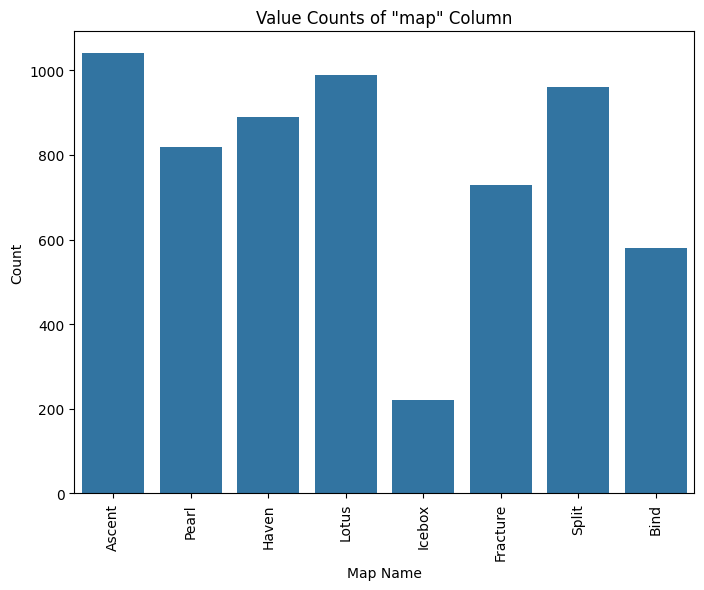

In [24]:
# calculate the average number of times a map is played
df['map'].value_counts().mean()


# Plot value counts using Seaborn
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='map')
plt.title('Value Counts of "map" Column')
plt.xlabel('Map Name')
plt.ylabel('Count')
plt.xticks(rotation='vertical')
plt.show()

Analysing the mean frequency at which these different maps are played, we find that the map "Icebox" is played significantly less than the mean number of times a map is generally played, making it a clear outlier. As is such, we can conclude that matches played on the map of Icebox should not be relied upon for further Valorant insights as their sample size is too small.

## How Much Do Assists Matter?
An assist is a statistic that is broadly a measure of team play. Generally speaking, a team with a higher total assist count can be said to have better team play, while a team with a lower assist count may rely more on individual player strength. That being said, how important are assists/strong teamplay in the success of a team?

At the end of 2023, the valorant team EG were crowned world champions by finishing first in the VCT. Does this also mean they got the most assists?

**Hypothesis**: The best valorant team has the most assists

**Null-Hypothesis**: The best valorant team does not have the assists

We will use a Mann-Whitney U test to determine if the team 'EG' has significantly more assists than other VCT contenders

Mann-Whitney U Test Results:
U-statistic: 1109443.0
P-value: 0.44852493255734427


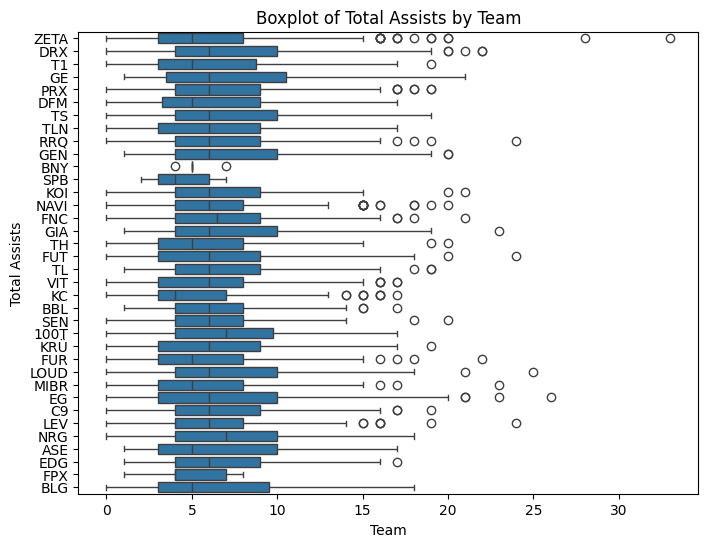

In [25]:
# Calculate EG's assists
eg_assists = df[df['team'] == 'EG']['assist']
# Calculate other teams assists
other_teams_assists = df[df['team'] != 'EG']['assist']

# Perform Mann-Whitney U test
u_stat, p_value = mannwhitneyu(eg_assists, other_teams_assists)

print("Mann-Whitney U Test Results:")
print("U-statistic:", u_stat)
print("P-value:", p_value)

# Visualize data
plt.figure(figsize=(8, 6))
sns.boxplot(x='assist', y='team', data=df)
plt.title('Boxplot of Total Assists by Team')
plt.xlabel('Team')
plt.ylabel('Total Assists')
plt.show()

With a resultant P-value of .44 and significance value of .05, we do not have sufficient data to reject our null-hypothesis. Therefore, we conclude that the best valorant team does not necessarily have the most assists. This is important as it underlines the individual talent of the players and tells us that individual play may have greater impact in valorant than perfect team play.

## Is the VCT Fair?
Here out of curiousity, I am questioning the validity of the VCT tournament system. It has notoriously been criticized for being lacking, so to test this, we will investiage the correlation between rounds won and team success.


Does The Best Team Have The Most Wins?
At the end of 2023, the valorant team EG were crowned world champions by finishing first in the VCT. Does this also mean they win the most rounds?

Hypothesis: The best valorant team has the most amount of round wins

Null-Hypothesis: The best valorant team does not have the most round wins

We will use a Ttest to determine if the team 'EG' has significantly more round wins than other VCT contenders.

T-test Results:
T-statistic: 3.86304077796613
P-value: 0.00011312062697493833


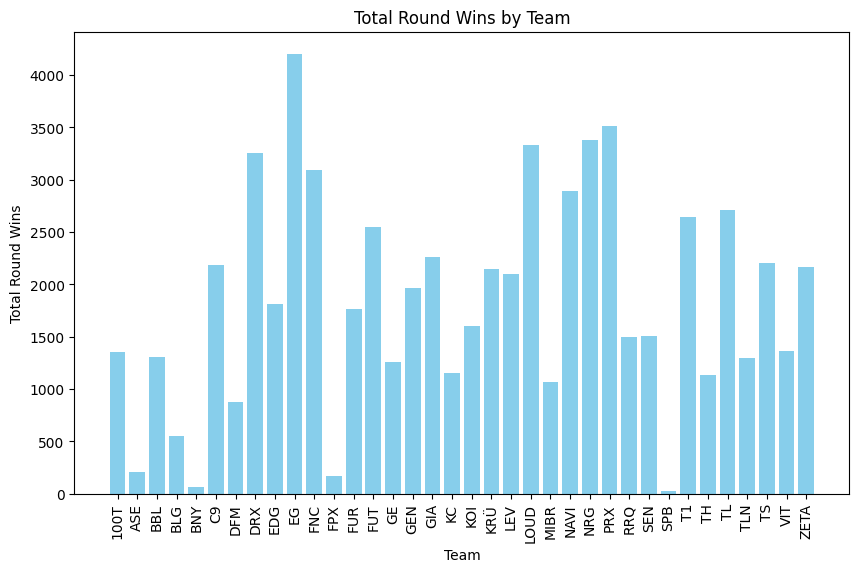

In [26]:
team_rounds_won = df.groupby('team')['score_team'].sum()

teamA_rounds_won = df[df['team'] == 'EG']['score_team']
other_teams_rounds_won = df[df['team'] != 'EG']['score_team']
t_stat, p_value = ttest_ind(teamA_rounds_won, other_teams_rounds_won)

print("T-test Results:")
print("T-statistic:", t_stat)
print("P-value:", p_value)

total_round_wins = df.groupby('team')['score_team'].sum().reset_index()

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(total_round_wins['team'], total_round_wins['score_team'], color='skyblue')
plt.title('Total Round Wins by Team')
plt.xlabel('Team')
plt.ylabel('Total Round Wins')
plt.xticks(rotation='vertical')
plt.show()


With a p-value of .0001 and significant level of .05, we can easily reject our null hypothesis and accept out hypothesis, proving that the best valorant team does in fact have the most round wins. This is important because the VCT format is flawed, meaning that every team might not play every other team, making it difficult to truly know whether the winner of the VCT is the best player. However, through this test we have concluded that infact the winner of the VCT is the best team in valorant.

## Kast to Determine Champions?
Assists do not seem to be able to definitively determine team success, but perhaps KAST score will. KAST is, as described before, Percentage of Kill, Assist, Survive, Trade.

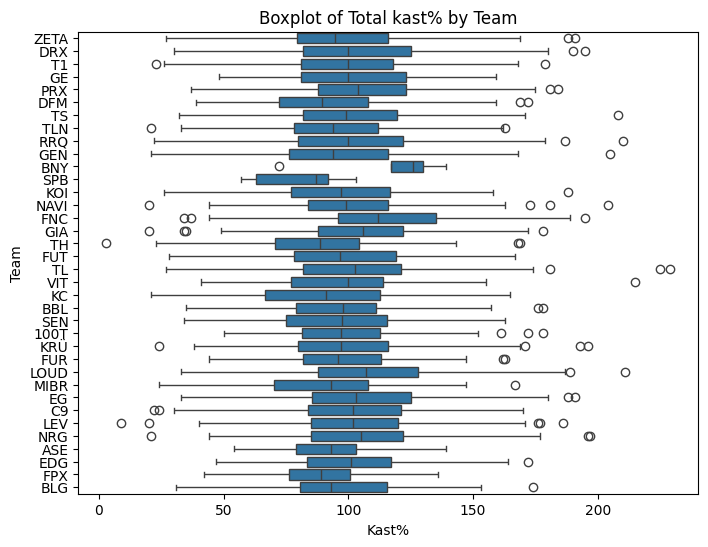

In [31]:
# Calculate EG's kast%
eg_kast = df[df['team'] == 'EG']['rating']
# Calculate other teams kast%
other_teams_kast = df[df['team'] != 'EG']['rating']


# Visualize data
plt.figure(figsize=(8, 6))
sns.boxplot(x='rating', y='team', data=df)
plt.title('Boxplot of Total kast% by Team')
plt.xlabel('Kast%')
plt.ylabel('Team')
plt.show()

Based on this visualization we can distinguish a 3 teams with the strongest avererage rating:
1. FNC
2. LOUD
3. EG  

While this data doesn't exactly place these teams in the right order, these 3 teams were widely considered to be the 3 best teams in the VCT and all had top 3 finishes. As a result, we can conclude that average rating can be used as a strong prediction measure.

## Primary Analysis
Based on the exploration of our data that we just completed, we have found that average rating can serve as a strong indicator of a teams succes, but how can we use this to predict the future success of a team given its players? To do this we will employ the power of Machine Learning. In this project, we will use the relatively simple method of **logistic regression** to build a machine learning model that will aid us in predicting success. We are choosing this model because it is well suited for simple binary classification tasks



#### **Logistic Regression**
Logistic regression is a statistical method used for binary classification tasks, where the goal is to predict the probability that an instance belongs to one of two possible classes. Despite its name, logistic regression is a classification algorithm rather than a regression algorithm.

In logistic regression, the algorithm models the probability that an instance belongs to a particular class using a logistic function (also known as the sigmoid function). The logistic function ensures that the predicted probabilities range between 0 and 1, which is suitable for binary classification. To do this, we will use the python library [scikit-learn](https://scikit-learn.org/).

In [42]:
# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Handle missing values
imputer = SimpleImputer(strategy='mean')
df['rating'] = imputer.fit_transform(df[['rating']])

# Extract features and target variable
X = df[['rating']]  # Features
y = df['win_lose']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a logistic regression model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.7118780096308186

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.72      0.72       628
           1       0.71      0.70      0.71       618

    accuracy                           0.71      1246
   macro avg       0.71      0.71      0.71      1246
weighted avg       0.71      0.71      0.71      1246


Confusion Matrix:
[[454 174]
 [185 433]]


## Visualization
We now have a trained model that will predict the outcome of a Valorant match based on the average rating of it's players, but how effective is this model? To better understand this, we will visualize the performance of our model by plotting the confusion matrix, rate of false positives and negatives, along with our precision recall curve.



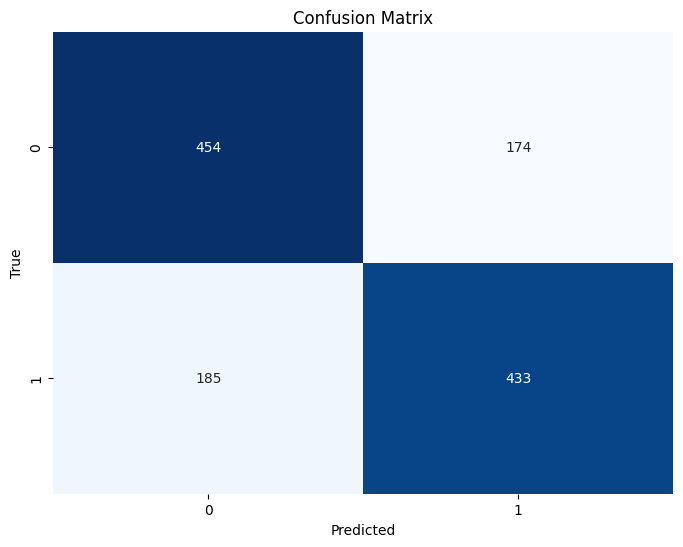

In [44]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


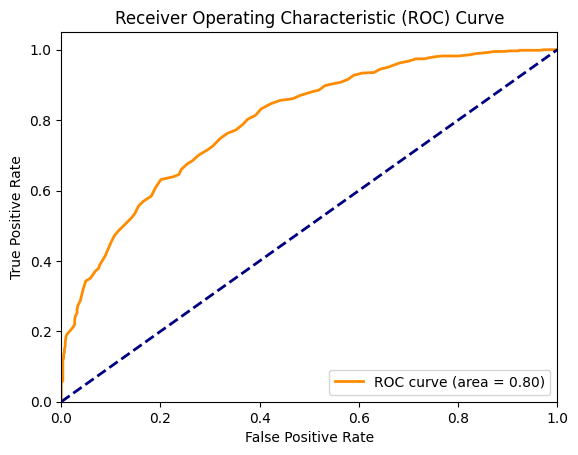

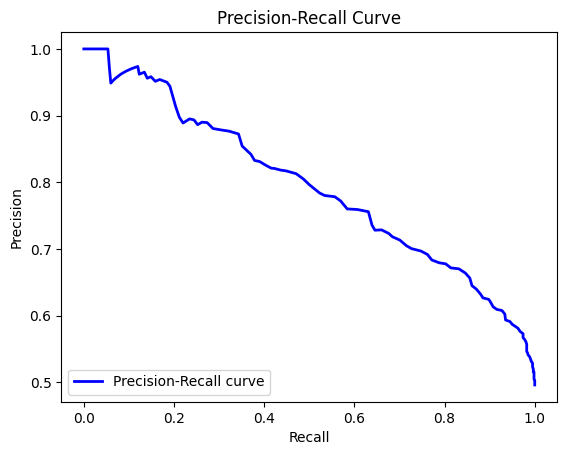

In [45]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


**Accuracy**: Through these visualizations, we can observe the performance of our model. The overall accuracy of the model is approximately 71.19%. Meaning that the model correctly predicts whether a team will win or lose a match about 71% of the time.

**Recall**: Looking at the classification report, we see that the precision and recall for both classes (win and lose) are similar, around 71%. Precision measures the proportion of true positives among all instances classified as positive, while recall measures the proportion of true positives that were correctly identified. These values suggest that the model is performing equally well in predicting both win and lose outcomes.

**Conclusion on Model Performance** While our model performs reasonably well to predict the outcome of a match, there is certainly room for improvement, particularly in reducing false negatives.To do this we could further tweak our hyperparameters or attempt to collect more data.

## Conclusion
Armed with a reasonbly accurrate predictive machine learning model, individuals and organizations alike can predict the succes of different player combinations. This has potentially to vastly improve the competitiveness of the VCT by creating stronger teams. In addition, through our primary analysis, we found that it is average rating in fact that is the best determiner of a team success. Since rating is a overall measure of skill in many categories, this finding suggests that to have the best chance of succes in the VCT, players must strive to be well-rounded players who are able to both support their team and shine individually.

It is also important to note that there are many factors of a teams success that were not, and arguably cannot be recorded statistically. This includes chemistry between players on a team, the support a teams gets from their parent organization, and many others. Nevertheless, this model serves project serves as a proof of concept that better leveraging statistical data from Valorant can lead to new insights and competitive advantage.  